## Setup and load data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git -qq
!git clone https://github.com/dungdx34/vtner.git -qq
!pip install underthesea -qq
!pip install python-crfsuite -qq
!pip install seqeval -qq
!wget http://nlp.stanford.edu/data/glove.6B.zip -qq
!unzip glove.6B.zip glove.6B.100d.txt -qq
!pip install transformers -qq
!pip install tensorflow-addons -qq
!git clone https://github.com/LiyuanLucasLiu/LM-LSTM-CRF.git -qq

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 82.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.5/993.5 kB 68.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 657.8/657.8 kB 63.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
Archive:  glove.6B.zip
  inflating: glove.6B.100d.txt       
caution: filename not matched:  -qq
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 35.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 59.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 61.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 42.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.3/612.3 kB 5.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd

def conll_to_dataframe(conll_file):
    with open(conll_file, 'r') as file:
        lines = file.readlines()

    rows = []
    for line in lines:
        line = line.strip()
        if line:  # if not an empty line
            rows.append(line.split("\t"))
        else:  # if it's an empty line
            rows.append(['', '', ''])  # add an empty row to the DataFrame

    df = pd.DataFrame(rows, columns=["Word", "POS-tag", "NER-tag"])
    return df

In [ ]:
train_df = conll_to_dataframe("/content/vtner/data/train.conll")
dev_df = conll_to_dataframe("/content/vtner/data/dev.conll")
test_df = conll_to_dataframe("/content/vtner/data/test.conll")

index = train_df[(train_df['Word'] == 'đường_sắt') & (train_df['POS-tag'] == 'B-LOC')].index

train_df.loc[index, 'POS-tag'], train_df.loc[index, 'NER-tag'] = 'O', 'B-LOC'

In [ ]:
def df_to_sentences(df):
    sentences = []
    sentence = []
    for _, row in df.iterrows():
        if row['Word'] == '':
            sentences.append(sentence)
            sentence = []
        else:
            sentence.append((row['Word'], row['POS-tag'], row['NER-tag'] if pd.notnull(row['NER-tag']) else 'O'))
    if sentence:
        sentences.append(sentence)
    return sentences

train_sentences = df_to_sentences(train_df)
dev_sentences = df_to_sentences(dev_df)
test_sentences = df_to_sentences(test_df)

In [ ]:
count = train_df['POS-tag'].value_counts()

print(count)

In [ ]:
train_sentences[3]

## CRF

In [ ]:
def extract_features(sentence, index, config, prediction=False):
    if prediction:
        word, pos = sentence[index]
    else:
        word, pos, ner = sentence[index]

    features = {
        'bias': 1.0,
        'word': word,
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word[:3]': word[:3],
        'word[:2]': word[:2],
        'word.isdigit()': word.isdigit(),
        'word.istitle()': word.istitle(),
        'word.isupper()': word.isupper(),
    }

    if config != "CRF-without tag":
        # Add POS tag feature
        features['postag'] = pos

    window_size = 3
    if config == "CRF-window 3":
        window_size = 1
    elif config == "CRF-window 5":
        window_size = 2

    for i in range(1, window_size + 1):
        if index - i >= 0:
            if prediction:
                prev_word, prev_pos = sentence[index - i]
            else:
                prev_word, prev_pos, _ = sentence[index - i]
            features[f'-{i}:word'] = prev_word
            if config != "CRF-without tag":
                features[f'-{i}:postag'] = prev_pos
        if index + i < len(sentence):
            if prediction:
                next_word, next_pos = sentence[index + i]
            else:
                next_word, next_pos, _ = sentence[index + i]
            features[f'+{i}:word'] = next_word
            if config != "CRF-without tag":
                features[f'+{i}:postag'] = next_pos

    return features

In [ ]:
import pycrfsuite

def train_crf_model(sentences, config):
    X_train = [[extract_features(s, i, config) for i in range(len(s))] for s in sentences]
    y_train = [[ner for word, pos, ner in s] for s in sentences]

    trainer = pycrfsuite.Trainer(verbose=False)
    for xseq, yseq in zip(X_train, y_train):
        if None in xseq or None in yseq:
            print(f"None value found in xseq: {xseq} or yseq: {yseq}")
        trainer.append(xseq, yseq)

    trainer.set_params({
        'c1': 1.0,
        'c2': 0.001,
        'max_iterations': 200,
        'feature.possible_transitions': True
    })

    model_path = "/content/drive/My Drive/crf_models/"
    trainer.train(f'{model_path}crf_model_{config}.pkl')

In [ ]:
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report

def evaluate_crf_model(dev_sentences, config):
    model_path = "/content/drive/My Drive/crf_models/"

    tagger = pycrfsuite.Tagger()
    tagger.open(f'{model_path}crf_model_{config}.pkl')

    y_pred = [tagger.tag([extract_features(s, i, config, prediction=False) for i in range(len(s))]) for s in dev_sentences]

    # Get the true label
    y_true = [[ner for word, pos, ner in s] for s in dev_sentences]
    entity_precision = precision_score(y_true, y_pred)
    entity_recall = recall_score(y_true, y_pred)
    entity_f1 = f1_score(y_true, y_pred)

    print(f"Evaluation for {config}:")
    print(classification_report(y_true, y_pred))
    print(f"Entity Precision: {entity_precision:.4f}")
    print(f"Entity Recall: {entity_recall:.4f}")
    print(f"Entity F1: {entity_f1:.4f}\n")


In [ ]:
configs = ["CRF", "CRF-without tag", "CRF-window 3", "CRF_window 5"]
for config in configs:
    train_crf_model(train_sentences, config)

In [ ]:
configs = ["CRF", "CRF-without tag", "CRF-window 3", "CRF_window 5"]
for config in configs:
    evaluate_crf_model(dev_sentences, config)

Evaluation for CRF:
              precision    recall  f1-score   support

         LOC       0.75      0.80      0.77       699
        MISC       0.71      0.39      0.50        31
         ORG       0.66      0.49      0.57       234
         PER       0.90      0.78      0.84       347

   micro avg       0.77      0.73      0.75      1311
   macro avg       0.76      0.62      0.67      1311
weighted avg       0.77      0.73      0.75      1311

Entity Precision: 0.7749
Entity Recall: 0.7300
Entity F1: 0.7518

Evaluation for CRF-without tag:
              precision    recall  f1-score   support

         LOC       0.75      0.78      0.77       699
        MISC       0.69      0.35      0.47        31
         ORG       0.65      0.44      0.53       234
         PER       0.93      0.76      0.84       347

   micro avg       0.78      0.71      0.74      1311
   macro avg       0.76      0.59      0.65      1311
weighted avg       0.78      0.71      0.74      1311

Entity Preci

In [ ]:
from underthesea import pos_tag
def prepare_sentence(sentence):

    words = sentence.split()

    words_and_tags = [pos_tag(word)[0] for word in words]
    return words_and_tags

In [ ]:
def predict_crf_model(sentence, config):
    tagger = pycrfsuite.Tagger()
    model_path = "/content/drive/My Drive/crf_models/"
    tagger.open(f'{model_path}crf_model_{config}.pkl')
    features = [extract_features(sentence, i, config, prediction =True) for i in range(len(sentence)) if sentence[i][0]]
    tags = tagger.tag(features)


    for word, tag in zip(sentence, tags):
        print(f'{word[0]}: {tag}')

sentence = "ông Huy dân tỉnh Đồng_Nai tại trường_đại_học Quốc_Tế có tài_khoản Facebook là Huy_Châu"
prepared_sentence = prepare_sentence(sentence)
config = "CRF_window 5"
predict_crf_model(prepared_sentence, config)

ông: O
Huy: B-PER
dân: O
tỉnh: B-LOC
Đồng_Nai: I-LOC
tại: O
trường_đại_học: B-ORG
Quốc_Tế: I-ORG
có: O
tài_khoản: O
Facebook: B-MISC
là: O
Huy_Châu: B-LOC


##LSTM-CRF

In [ ]:
!python /content/LM-LSTM-CRF/train_w.py --emb_file /content/glove.6B.100d.txt --train_file /content/vtner/data/train.conll --dev_file /content/vtner/data/dev.conll --test_file /content/vtner/data/test.conll --gpu 0 --batch_size 32 --drop_out 0.5 --embedding_dim 100 --layers 2 --epoch 1000 --lr 0.01 --lr_decay 0 --hidden 50 --update sgd --clip_grad 5.0  --checkpoint /content/drive/MyDrive/NERmodel/ --caseless --fine_tune --eva_matrix fa --patience 20 --least_iters 150

setting:
Namespace(rand_embedding=False, emb_file='/content/glove.6B.100d.txt', train_file='/content/vtner/data/train.conll', dev_file='/content/vtner/data/dev.conll', test_file='/content/vtner/data/test.conll', gpu=0, batch_size=32, unk='unk', checkpoint='/content/drive/MyDrive/NERmodel/', hidden=50, drop_out=0.5, epoch=1000, start_epoch=0, caseless=True, embedding_dim=100, layers=2, lr=0.01, lr_decay=0.0, fine_tune=False, load_check_point='', load_opt=False, update='sgd', momentum=0.9, clip_grad=5.0, small_crf=True, mini_count=5, eva_matrix='fa', patience=20, least_iters=150, shrink_embedding=False)
loading corpus
constructing coding table
feature size: '2004'
loading embedding
embedding size: '401500'
building model
random initialization
device: 0
 - Tot it 100 (epoch 0): 0it [00:00, ?it/s]/content/LM-LSTM-CRF/model/crf.py:287: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/Index

In [ ]:
content = """
-DOCSTART-

ông
Huy
dân
tỉnh
Đồng_Nai
tại
trường_đại_học
Quốc_Tế
có
tài_khoản
Facebook
và
tài_khoản
Youtube
là
Huy_Châu
"""

with open('inference.txt', 'w') as file:
    file.write(content)

!ls -lh inference.txt


-rw-r--r-- 1 root root 162 Oct 13 15:32 inference.txt


In [ ]:
!python /content/LM-LSTM-CRF/seq_w.py --load_arg /content/drive/MyDrive/NERmodel/lstm_crf.json --load_check_point /content/drive/MyDrive/NERmodel/lstm_crf.model --gpu 0 --input_file /content/inference.txt --output_file lstm_crf.txt

loading dictionary
loading corpus
loading model
annotating
 - Process:   0% 0/1 [00:00<?, ?it/s]/content/LM-LSTM-CRF/model/crf.py:372: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/cuda/Indexing.cu:1440.)
  cur_bp.masked_fill_(mask[idx].view(bat_size, 1).expand(bat_size, self.tagset_size), self.end_tag)


In [ ]:
with open('/content/lstm_crf.txt', 'r') as file:
    for line in file:
        print(line, end='')

-DOCSTART- -DOCSTART- -DOCSTART-

ông <PER> Huy </PER> dân <LOC> tỉnh Đồng_Nai </LOC> tại trường_đại_học Quốc_Tế có tài_khoản <MISC> Facebook </MISC> và tài_khoản Youtube là Huy_Châu 



In [ ]:
!python /content/LM-LSTM-CRF/train_w.py --emb_file /content/glove.6B.100d.txt --train_file /content/vtner/data/train.conll --dev_file /content/vtner/data/dev.conll --test_file /content/vtner/data/test.conll --gpu 0 --batch_size 32 --drop_out 0.5 --embedding_dim 100 --layers 2 --epoch 1000 --lr 0.01 --lr_decay 0 --hidden 50 --update sgd --clip_grad 5.0  --checkpoint /content/drive/MyDrive/NERmodel/ --caseless --fine_tune --eva_matrix fa --patience 20 --least_iters 150

## LSTM-CRF-CAP-POS

### Read text and label

In [ ]:
def read_corpus(sentences):
    features = list()
    labels = list()
    for sentence in sentences:
        tmp_fl = list()
        tmp_ll = list()
        for line in sentence:
            word, pos, ner = line
            tmp_fl.append((word, pos, word[0].isupper()))
            tmp_ll.append(ner)
        if len(tmp_fl) > 0:
            features.append(tmp_fl)
            labels.append(tmp_ll)

    return features, labels

def shrink_features(feature_map, features, thresholds):
    feature_count = {k: 0 for k in feature_map}
    for feature_list in features:
        for feature in feature_list:
            feature_count[feature] += 1
    shrinked_feature_count = [k for k, v in feature_count.items() if v >= thresholds]
    feature_map = {feature: (ind + 1) for ind, feature in enumerate(shrinked_feature_count)}

    feature_map[('<unk>', '<unk>', False)] = 0
    feature_map[('<eof>', '<eof>', False)] = len(feature_map)

    return feature_map

def generate_corpus(lines, thresholds=1):

    features, labels = read_corpus(lines)
    unique_features = set(f for sentence in features for f in sentence)
    feature_map = {feature: i for i, feature in enumerate(unique_features, start=1)}
    label_map = {label: i for i, label in enumerate(set(label for sentence in labels for label in sentence))}
    feature_map = shrink_features(feature_map, features, thresholds)
    label_map['<start>'] = len(label_map)
    label_map['<pad>'] = len(label_map)

    return features, labels, feature_map, label_map

In [ ]:
train_features, train_labels, f_map, l_map = generate_corpus(train_sentences)
dev_features, dev_labels, f_dev_map, l_dev_map = generate_corpus(dev_sentences)
test_features, test_labels, f_test_map, l_test_map = generate_corpus(test_sentences)

In [ ]:
train_features[3]

[('Quảng_Bình', 'Np', True),
 ('muốn', 'V', False),
 ('bổ_sung', 'V', False),
 ('vào', 'V', False),
 ('quy_hoạch', 'V', False),
 ('khu', 'N', False),
 ('du_lịch', 'V', False),
 ('Vườn_quốc_gia', 'N', True),
 ('Phong_Nha', 'Np', True),
 ('-', '-', False),
 ('Kẻ_Bàng', 'Np', True),
 ('tuyến', 'N', False),
 ('cáp', 'N', False),
 ('treo', 'V', False),
 ('dài', 'A', False),
 ('5,2', 'M', False),
 ('km', 'Nu', False)]

### Generate embedding and fulfill feature map

In [ ]:
import functools
f_map = shrink_features(f_map, train_features, 5)

l_set = functools.reduce(lambda x, y: x | y, map(lambda t: set(t), dev_labels))
l_set = functools.reduce(lambda x, y: x | y, map(lambda t: set(t), test_labels), l_set)
for label in l_set:
    if label not in l_map:
        l_map[label] = len(l_map)


full_feature_set = {**f_map, **f_dev_map, **f_test_map}
len(full_feature_set)

In [ ]:
import numpy as np
import torch

import torch.nn as nn
import torch.nn.init
def init_embedding(input_embedding):

    bias = np.sqrt(3.0 / input_embedding.size(1))
    nn.init.uniform_(input_embedding, -bias, bias)

def load_embedding_wlm(emb_file, delimiter, full_feature_set, unk, emb_len):

    word_dict = {(key[0], key[1], key[2]): (k+1) for (k, key) in enumerate(full_feature_set.keys()) if key[0] != '<unk>'}
    word_dict[('<unk>', '<unk>', False)] = 0

    word_to_key_map = {k[0]: k for k in full_feature_set}
    rand_embedding_tensor = torch.FloatTensor(len(word_dict), emb_len)
    init_embedding(rand_embedding_tensor)
    out_doc_embedding_list = []
    with open(emb_file, 'r') as file:
        for line in file:
            line = line.split(delimiter)
            word = line[0]
            vector = [float(t) for t in line[1:] if t.strip()]

            if word == unk:
                rand_embedding_tensor[0] = torch.FloatTensor(vector)
            else:
                original_key = word_to_key_map.get(word, None)
                if original_key:
                    rand_embedding_tensor[word_dict[original_key]] = torch.FloatTensor(vector)
                else:
                    out_doc_embedding_list.append(vector)
                    word_dict[(word, 'N', False)] = len(word_dict)
    embedding_tensor_0 = torch.FloatTensor(out_doc_embedding_list)
    embedding_tensor = torch.cat([rand_embedding_tensor, embedding_tensor_0], 0)
    return word_dict, embedding_tensor

In [ ]:
f_map, embedding_tensor = load_embedding_wlm('/content/glove.6B.100d.txt', ' ', full_feature_set, unk='<unk>', emb_len=100)

### Bucketing data with padding and bi-gram encoding

In [ ]:
def calc_threshold_mean(features):

    lines_len = list(map(lambda t: len(t) + 1, features))
    average = int(sum(lines_len) / len(lines_len))
    lower_line = list(filter(lambda t: t < average, lines_len))
    upper_line = list(filter(lambda t: t >= average, lines_len))
    lower_average = int(sum(lower_line) / len(lower_line))
    upper_average = int(sum(upper_line) / len(upper_line))
    max_len = max(lines_len)
    return [lower_average, average, upper_average, max_len]

In [ ]:
import numpy as np
from torch.utils.data import Dataset
class CRFDataset(Dataset):

    def __init__(self, data_tensor, label_tensor, mask_tensor):
        assert data_tensor.size(0) == label_tensor.size(0)
        assert data_tensor.size(0) == mask_tensor.size(0)
        self.data_tensor = data_tensor
        self.label_tensor = label_tensor
        self.mask_tensor = mask_tensor

    def __getitem__(self, index):
        return self.data_tensor[index], self.label_tensor[index], self.mask_tensor[index]

    def __len__(self):
        return self.data_tensor.size(0)

def construct_bucket_vb(input_features, input_labels, thresholds, pad_feature, pad_label, label_size):

    buckets = [[[], [], []] for _ in range(len(thresholds))]
    for feature, label in zip(input_features, input_labels):

        cur_len = len(feature)
        idx = 0
        cur_len_1 = cur_len + 1
        while thresholds[idx] < cur_len_1:
            idx += 1
        buckets[idx][0].append(feature + [pad_feature] * (thresholds[idx] - cur_len))
        buckets[idx][1].append([label[ind] * label_size + label[ind + 1] for ind in range(0, cur_len)] + [
            label[cur_len] * label_size + pad_label] + [pad_label * label_size + pad_label] * (
                                       thresholds[idx] - cur_len_1))
        buckets[idx][2].append([1] * cur_len_1 + [0] * (thresholds[idx] - cur_len_1))

    bucket_dataset = [CRFDataset(torch.LongTensor(bucket[0]), torch.LongTensor(bucket[1]), torch.ByteTensor(bucket[2]))
                      for bucket in buckets]
    return bucket_dataset

In [ ]:
def encode_safe(input_lines, f_map, unk):

    encoded_lines = []
    for line in input_lines:
        encoded_line = []
        for item in line:
            if len(item) == 3:
                word, pos, cap = item
                encoded_line.append(f_map.get((word, pos, cap), unk))
            else:
                print(f"Unexpected item in line: {item}")
                encoded_line.append(unk)
        encoded_lines.append(encoded_line)
    return encoded_lines


def encode(input_lines, word_dict):

    lines = list(map(lambda t: list(map(lambda m: word_dict[m], t)), input_lines))
    return lines

def construct_bucket_mean_vb(input_features, input_label, word_dict, label_dict):

    features = encode_safe(input_features, word_dict, word_dict[('<unk>', '<unk>', False)])
    labels = encode(input_label, label_dict)
    labels = list(map(lambda t: [label_dict['<start>']] + list(t), labels))

    thresholds = calc_threshold_mean(features)

    return construct_bucket_vb(features, labels, thresholds, word_dict[('<eof>', '<eof>', False)], label_dict['<pad>'], len(label_dict))

In [ ]:
train_buckets = construct_bucket_mean_vb(train_features, train_labels, f_map, l_map)
dev_buckets = construct_bucket_mean_vb(dev_features, dev_labels, f_map, l_map)
test_buckets = construct_bucket_mean_vb(test_features, test_labels, f_map, l_map)

In [ ]:
dataset_loader = [torch.utils.data.DataLoader(tup, 32, shuffle=True, drop_last=False) for tup in train_buckets]
dev_dataset_loader = [torch.utils.data.DataLoader(tup, 50, shuffle=False, drop_last=False) for tup in dev_buckets]
test_dataset_loader = [torch.utils.data.DataLoader(tup, 50, shuffle=False, drop_last=False) for tup in test_buckets]

### Define model

In [ ]:
def init_linear(input_linear):

    bias = np.sqrt(6.0 / (input_linear.weight.size(0) + input_linear.weight.size(1)))
    nn.init.uniform_(input_linear.weight, -bias, bias)
    if input_linear.bias is not None:
        input_linear.bias.data.zero_()


class CRF_S(nn.Module):

    def __init__(self, hidden_dim, tagset_size, if_bias=True):
        super(CRF_S, self).__init__()
        self.tagset_size = tagset_size
        self.hidden2tag = nn.Linear(hidden_dim, self.tagset_size, bias=if_bias)
        self.transitions = nn.Parameter(torch.Tensor(self.tagset_size, self.tagset_size))

    def rand_init(self):

        init_linear(self.hidden2tag)
        self.transitions.data.zero_()

    def forward(self, feats):

        scores = self.hidden2tag(feats).view(-1, self.tagset_size, 1)
        ins_num = scores.size(0)
        crf_scores = scores.expand(ins_num, self.tagset_size, self.tagset_size) + self.transitions.view(1, self.tagset_size, self.tagset_size).expand(ins_num, self.tagset_size, self.tagset_size)

        return crf_scores

class CRFRepack:

    def __init__(self, tagset_size, if_cuda):

        self.tagset_size = tagset_size
        self.if_cuda = if_cuda

    def repack_vb(self, feature, target, mask):

        if self.if_cuda:
            fea_v = feature.transpose(0, 1).cuda()
            tg_v = target.transpose(0, 1).unsqueeze(2).cuda()
            mask_v = mask.transpose(0, 1).cuda()
        else:
            fea_v = feature.transpose(0, 1)
            tg_v = target.transpose(0, 1).contiguous().unsqueeze(2)
            mask_v = mask.transpose(0, 1).contiguous()
        return fea_v, tg_v, mask_v

    def repack_gd(self, feature, target, current):

        if self.if_cuda:
            fea_v = feature.transpose(0, 1).cuda()
            ts_v = target.transpose(0, 1).cuda().view(-1)
            cs_v = current.transpose(0, 1).cuda().view(-1, 1, 1)
        else:
            fea_v = feature.transpose(0, 1)
            ts_v = target.transpose(0, 1).contiguous().view(-1)
            cs_v = current.transpose(0, 1).contiguous().view(-1, 1, 1)
        return fea_v, ts_v, cs_v

    def convert_for_eval(self, target):

        return target % self.tagset_size


In [ ]:
def log_sum_exp(vec, m_size):

    _, idx = torch.max(vec, 1)
    max_score = torch.gather(vec, 1, idx.view(-1, 1, m_size)).view(-1, 1, m_size)  # B * M

    return max_score.view(-1, m_size) + torch.log(torch.sum(torch.exp(vec - max_score.expand_as(vec)), 1)).view(-1, m_size)

class CRFLoss_vb(nn.Module):

    def __init__(self, tagset_size, start_tag, end_tag, average_batch=True):
        super(CRFLoss_vb, self).__init__()
        self.tagset_size = tagset_size
        self.start_tag = start_tag
        self.end_tag = end_tag
        self.average_batch = average_batch

    def forward(self, scores, target, mask):

        seq_len = scores.size(0)
        bat_size = scores.size(1)

        tg_energy = torch.gather(scores.view(seq_len, bat_size, -1), 2, target).view(seq_len, bat_size)  # seq_len * bat_size
        tg_energy = tg_energy.masked_select(mask).sum()


        seq_iter = enumerate(scores)

        _, inivalues = seq_iter.__next__()

        partition = inivalues[:, self.start_tag, :].clone()

        for idx, cur_values in seq_iter:
            cur_values = cur_values + partition.contiguous().view(bat_size, self.tagset_size, 1).expand(bat_size, self.tagset_size, self.tagset_size)
            cur_partition = log_sum_exp(cur_values, self.tagset_size)
            mask_idx = mask[idx, :].view(bat_size, 1).expand(bat_size, self.tagset_size)
            partition.masked_scatter_(mask_idx, cur_partition.masked_select(mask_idx))


        partition = partition[:, self.end_tag].sum()

        if self.average_batch:
            loss = (partition - tg_energy) / bat_size
        else:
            loss = (partition - tg_energy)

        return loss

In [ ]:
import torch
import torch.autograd as autograd
import torch.nn as nn
def init_lstm(input_lstm):

    for ind in range(0, input_lstm.num_layers):
        weight = eval('input_lstm.weight_ih_l'+str(ind))
        bias = np.sqrt(6.0 / (weight.size(0)/4 + weight.size(1)))
        nn.init.uniform_(weight, -bias, bias)
        weight = eval('input_lstm.weight_hh_l'+str(ind))
        bias = np.sqrt(6.0 / (weight.size(0)/4 + weight.size(1)))
        nn.init.uniform_(weight, -bias, bias)

    if input_lstm.bias:
        for ind in range(0, input_lstm.num_layers):
            weight = eval('input_lstm.bias_ih_l'+str(ind))
            weight.data.zero_()
            weight.data[input_lstm.hidden_size: 2 * input_lstm.hidden_size] = 1
            weight = eval('input_lstm.bias_hh_l'+str(ind))
            weight.data.zero_()
            weight.data[input_lstm.hidden_size: 2 * input_lstm.hidden_size] = 1

class LSTM_CRF(nn.Module):

    def __init__(self, vocab_size, tagset_size, embedding_dim, hidden_dim, rnn_layers, dropout_ratio, large_CRF=True):
        super(LSTM_CRF, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size

        self.word_embeds = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim // 2,
                            num_layers=rnn_layers, bidirectional=True, dropout=dropout_ratio)
        self.rnn_layers = rnn_layers

        self.dropout1 = nn.Dropout(p=dropout_ratio)
        self.dropout2 = nn.Dropout(p=dropout_ratio)

        self.tagset_size = tagset_size


        self.crf = CRF_S(hidden_dim, tagset_size)

        self.batch_size = 1
        self.seq_length = 1

    def rand_init_hidden(self):

        return autograd.Variable(
            torch.randn(2 * self.rnn_layers, self.batch_size, self.hidden_dim // 2)), autograd.Variable(
            torch.randn(2 * self.rnn_layers, self.batch_size, self.hidden_dim // 2))

    def set_batch_size(self, bsize):

        self.batch_size = bsize

    def set_batch_seq_size(self, sentence):

        tmp = sentence.size()
        self.seq_length = tmp[0]
        self.batch_size = tmp[1]

    def load_pretrained_embedding(self, pre_embeddings):

        assert (pre_embeddings.size()[1] == self.embedding_dim)
        self.word_embeds.weight = nn.Parameter(pre_embeddings)

    def rand_init_embedding(self):
        init_embedding(self.word_embeds.weight)

    def rand_init(self, init_embedding=False):

        init_lstm(self.lstm)
        self.crf.rand_init()

    def forward(self, sentence, hidden=None):

        self.set_batch_seq_size(sentence)

        embeds = self.word_embeds(sentence)
        d_embeds = self.dropout1(embeds)

        lstm_out, hidden = self.lstm(d_embeds, hidden)
        lstm_out = lstm_out.view(-1, self.hidden_dim)

        d_lstm_out = self.dropout2(lstm_out)

        crf_out = self.crf(d_lstm_out)
        crf_out = crf_out.view(self.seq_length, self.batch_size, self.tagset_size, self.tagset_size)
        return crf_out, hidden

In [ ]:
import torch.optim as optim
ner_model = LSTM_CRF(len(f_map), len(l_map), 100, 50, 2, 0.5, large_CRF=True)
ner_model.load_pretrained_embedding(embedding_tensor)
ner_model.rand_init(init_embedding=False)
optimizer = optim.SGD(ner_model.parameters(), lr=0.01, momentum=0.9)
crit = CRFLoss_vb(len(l_map), l_map['<start>'], l_map['<pad>'])

In [ ]:
torch.cuda.set_device(0)
crit.cuda()
ner_model.cuda()
packer = CRFRepack(len(l_map), True)

In [ ]:
def iobes_to_spans(sequence, lut, strict_iob2=False):
    """
    convert to iobes to span
    """
    iobtype = 2 if strict_iob2 else 1
    chunks = []
    current = None

    for i, y in enumerate(sequence):
        label = lut[y]

        if label.startswith('B-'):

            if current is not None:
                chunks.append('@'.join(current))
            current = [label.replace('B-', ''), '%d' % i]

        elif label.startswith('S-'):

            if current is not None:
                chunks.append('@'.join(current))
                current = None
            base = label.replace('S-', '')
            chunks.append('@'.join([base, '%d' % i]))

        elif label.startswith('I-'):

            if current is not None:
                base = label.replace('I-', '')
                if base == current[0]:
                    current.append('%d' % i)
                else:
                    chunks.append('@'.join(current))
                    if iobtype == 2:
                        print('Warning')
                    current = [base, '%d' % i]

            else:
                current = [label.replace('I-', ''), '%d' % i]
                if iobtype == 2:
                    print('Warning')

        elif label.startswith('E-'):

            if current is not None:
                base = label.replace('E-', '')
                if base == current[0]:
                    current.append('%d' % i)
                    chunks.append('@'.join(current))
                    current = None
                else:
                    chunks.append('@'.join(current))
                    if iobtype == 2:
                        print('Warning')
                    current = [base, '%d' % i]
                    chunks.append('@'.join(current))
                    current = None

            else:
                current = [label.replace('E-', ''), '%d' % i]
                if iobtype == 2:
                    print('Warning')
                chunks.append('@'.join(current))
                current = None
        else:
            if current is not None:
                chunks.append('@'.join(current))
            current = None

    if current is not None:
        chunks.append('@'.join(current))

    return set(chunks)

In [ ]:
class CRFDecode_vb():

    def __init__(self, tagset_size, start_tag, end_tag, average_batch=True):
        self.tagset_size = tagset_size
        self.start_tag = start_tag
        self.end_tag = end_tag
        self.average_batch = average_batch

    def decode(self, scores, mask):

        seq_len = scores.size(0)
        bat_size = scores.size(1)

        mask = 1 - mask
        decode_idx = torch.LongTensor(seq_len-1, bat_size)


        seq_iter = enumerate(scores)

        _, inivalues = seq_iter.__next__()

        forscores = inivalues[:, self.start_tag, :]
        back_points = list()

        for idx, cur_values in seq_iter:
            cur_values = cur_values + forscores.contiguous().view(bat_size, self.tagset_size, 1).expand(bat_size, self.tagset_size, self.tagset_size)

            forscores, cur_bp = torch.max(cur_values, 1)
            cur_bp.masked_fill_(mask[idx].view(bat_size, 1).expand(bat_size, self.tagset_size), self.end_tag)
            back_points.append(cur_bp)

        pointer = back_points[-1][:, self.end_tag]
        decode_idx[-1] = pointer
        for idx in range(len(back_points)-2, -1, -1):
            back_point = back_points[idx]
            index = pointer.contiguous().view(-1,1)
            pointer = torch.gather(back_point, 1, index).view(-1)
            decode_idx[idx] = pointer
        return decode_idx

In [ ]:
import itertools
def revlut(lut):
    return {v: k for k, v in lut.items()}

def find_length_from_labels(labels, label_to_ix):
    """
    find length of unpadded features based on labels
    """
    end_position = len(labels) - 1
    for position, label in enumerate(labels):
        if label == label_to_ix['<pad>']:
            end_position = position
            break
    return end_position

class eval_batch:

    def __init__(self, packer, l_map):
        self.packer = packer
        self.l_map = l_map
        self.r_l_map = revlut(l_map)
        self.totalp_counts={}
        self.truep_counts={}
        self.fn_counts={}
        self.fp_counts={}
        self.f1={}

    def reset(self):

        self.correct_labels = 0
        self.total_labels = 0
        self.gold_count = 0
        self.guess_count = 0
        self.overlap_count = 0
        self.totalp_counts={}
        self.truep_counts={}
        self.fn_counts={}
        self.fp_counts={}
        self.f1={}

    def calc_f1_batch(self, decoded_data, target_data):

        batch_decoded = torch.unbind(decoded_data, 1)
        batch_targets = torch.unbind(target_data, 0)

        for decoded, target in zip(batch_decoded, batch_targets):
            gold = self.packer.convert_for_eval(target)
            # remove padding
            length = find_length_from_labels(gold, self.l_map)
            gold = gold[:length]
            best_path = decoded[:length]

            correct_labels_i, total_labels_i, gold_count_i, guess_count_i, overlap_count_i = self.eval_instance(best_path.numpy(), gold.numpy())
            self.correct_labels += correct_labels_i
            self.total_labels += total_labels_i
            self.gold_count += gold_count_i
            self.guess_count += guess_count_i
            self.overlap_count += overlap_count_i

    def calc_acc_batch(self, decoded_data, target_data):

        batch_decoded = torch.unbind(decoded_data, 1)
        batch_targets = torch.unbind(target_data, 0)

        for decoded, target in zip(batch_decoded, batch_targets):
            gold = self.packer.convert_for_eval(target)

            length = find_length_from_labels(gold, self.l_map)
            gold = gold[:length].numpy()
            best_path = decoded[:length].numpy()

            self.total_labels += length
            self.correct_labels += np.sum(np.equal(best_path, gold))

    def f1_score(self):
        """
        calculate f1 score based on statics
        """
        if self.guess_count == 0:
            return {'total': (0.0, 0.0, 0.0, 0.0, '')}
        precision = self.overlap_count / float(self.guess_count)
        recall = self.overlap_count / float(self.gold_count)
        if precision == 0.0 or recall == 0.0:
            return {'total': (0.0, 0.0, 0.0, 0.0, '')}
        f = 2 * (precision * recall) / (precision + recall)
        accuracy = float(self.correct_labels) / self.total_labels
        message=""
        self.f1['total'] = (f, precision, recall, accuracy, message)
        for label in self.totalp_counts:
            tp = self.truep_counts.get(label,1)
            fn = sum(self.fn_counts.get(label,{}).values())
            fp = sum(self.fp_counts.get(label,{}).values())
            precision = tp / float(tp+fp+1e-9)
            recall = tp / float(tp+fn+1e-9)
            f = 2 * (precision * recall) / (precision + recall+1e-9)
            message = str(self.fn_counts.get(label, {}))
            self.f1[label] = (f, precision, recall, 0, message)
        return self.f1

    def acc_score(self):

        if 0 == self.total_labels:
            return 0.0
        accuracy = float(self.correct_labels) / self.total_labels
        return accuracy

    def eval_instance(self, best_path, gold):

        total_labels = len(best_path)
        correct_labels = np.sum(np.equal(best_path, gold))
        for i in range(total_labels):
            gold_label = self.r_l_map[gold[i]]
            guessed_label = self.r_l_map[best_path[i]]
            self.totalp_counts[gold_label] = 1 + self.totalp_counts.get(gold_label,0)
            if gold_label == guessed_label:
                self.truep_counts[gold_label] = 1 + self.truep_counts.get(gold_label,0)
            else:
                val = self.fn_counts.get(gold_label,{})
                val[guessed_label] = 1+ val.get(guessed_label,0)
                self.fn_counts[gold_label]=val

                val2 = self.fp_counts.get(guessed_label,{})
                val2[gold_label] = 1+ val2.get(gold_label,0)
                self.fp_counts[guessed_label] = val2

        gold_chunks = iobes_to_spans(gold, self.r_l_map)
        gold_count = len(gold_chunks)

        guess_chunks = iobes_to_spans(best_path, self.r_l_map)
        guess_count = len(guess_chunks)

        overlap_chunks = gold_chunks & guess_chunks
        overlap_count = len(overlap_chunks)

        return correct_labels, total_labels, gold_count, guess_count, overlap_count
class eval_w(eval_batch):

    def __init__(self, packer, l_map, score_type):
        eval_batch.__init__(self, packer, l_map)

        self.decoder = CRFDecode_vb(len(l_map), l_map['<start>'], l_map['<pad>'])

        if 'f' in score_type:
            self.eval_b = self.calc_f1_batch
            self.calc_s = self.f1_score
        else:
            self.eval_b = self.calc_acc_batch
            self.calc_s = self.acc_score

    def calc_score(self, ner_model, dataset_loader):

        ner_model.eval()
        self.reset()

        for feature, tg, mask in itertools.chain.from_iterable(dataset_loader):
            fea_v, _, mask_v = self.packer.repack_vb(feature, tg, mask)
            scores, _ = ner_model(fea_v)
            decoded = self.decoder.decode(scores.data, mask_v.data)
            self.eval_b(decoded, tg)

        return self.calc_s()

In [ ]:
import time
tot_length = sum(map(lambda t: len(t), dataset_loader))
best_f1 = float('-inf')
best_acc = float('-inf')
track_list = list()
start_time = time.time()
epoch_list = range(0, 1000)
patience_count = 0
evaluator = eval_w(packer, l_map, 'fa')

In [ ]:
import json
def to_scalar(var):
    return var.view(-1).data.tolist()[0]
def save_checkpoint(state, track_list, filename):

    with open(filename+'.json', 'w') as f:
        json.dump(track_list, f)
    torch.save(state, filename+'.model')
def adjust_learning_rate(optimizer, lr):

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [ ]:
from tqdm import tqdm
import sys
checkpoint = "/content/drive/MyDrive/NER_final/"
start_epoch = 0
epoch = 1000
for epoch_idx, start_epoch in enumerate(epoch_list):
        epoch_loss = 0
        ner_model.train()

        for feature, tg, mask in tqdm(
                itertools.chain.from_iterable(dataset_loader), mininterval=2,
                desc=' - Tot it %d (epoch %d)' % (tot_length, 0), leave=False, file=sys.stdout):

            fea_v, tg_v, mask_v = packer.repack_vb(feature, tg, mask)
            ner_model.zero_grad()
            scores, hidden = ner_model.forward(fea_v)
            loss = crit.forward(scores, tg_v, mask_v)
            loss.backward()
            nn.utils.clip_grad_norm_(ner_model.parameters(), 0.5)
            optimizer.step()
            epoch_loss += to_scalar(loss)
        adjust_learning_rate(optimizer, 0.01 / (1 + (0 + 1) * 0))
        epoch_loss /= tot_length


        if 'f' in 'fa':
            dev_result = evaluator.calc_score(ner_model, dev_dataset_loader)
            for label, (dev_f1, dev_pre, dev_rec, dev_acc, msg) in dev_result.items():
                print('DEV : %s : dev_f1: %.4f dev_rec: %.4f dev_pre: %.4f dev_acc: %.4f | %s\n' % (label, dev_f1, dev_pre, dev_rec, dev_acc, msg))
            (dev_f1, dev_pre, dev_rec, dev_acc, msg) = dev_result['total']

            if dev_f1 > best_f1:
                patience_count = 0
                best_f1 = dev_f1

                test_result = evaluator.calc_score(ner_model, test_dataset_loader)
                for label, (test_f1, test_pre, test_rec, test_acc, msg) in test_result.items():
                    print('TEST : %s : test_f1: %.4f test_rec: %.4f test_pre: %.4f test_acc: %.4f | %s\n' % (label, test_f1, test_rec, test_pre, test_acc, msg))
                (test_f1, test_rec, test_pre, test_acc, msg) = test_result['total']

                track_list.append(
                    {'loss': epoch_loss, 'dev_f1': dev_f1, 'dev_acc': dev_acc, 'test_f1': test_f1,
                     'test_acc': test_acc})

                print(
                    '(loss: %.4f, epoch: %d, dev F1 = %.4f, dev acc = %.4f, F1 on test = %.4f, acc on test= %.4f, f_map: %d, l_map: %d), saving...' %
                    (epoch_loss,
                     start_epoch,
                     dev_f1,
                     dev_acc,
                     test_f1,
                     test_acc,
                     len(f_map),
                     len(l_map)))

                try:
                    save_checkpoint({
                        'epoch': start_epoch,
                        'state_dict': ner_model.state_dict(),
                        'optimizer': optimizer.state_dict(),
                        'f_map': f_map,
                        'l_map': l_map,
                    }, {'track_list': track_list
                        }, checkpoint + 'lstm_crf')
                except Exception as inst:
                    print(inst)

            else:
                patience_count += 1
                print('(loss: %.4f, epoch: %d, dev F1 = %.4f, dev acc = %.4f)' %
                      (epoch_loss,
                       start_epoch,
                       dev_f1,
                       dev_acc))
                track_list.append({'loss': epoch_loss, 'dev_f1': dev_f1, 'dev_acc': dev_acc})

        print('epoch: ' + str(start_epoch) + '\t in ' + str(epoch) + ' take: ' + str(
            time.time() - start_time) + ' s')

        if patience_count >= 20 and start_epoch >= 150:
            break
def eprint(*args, **kwargs):
    print(*args, file=sys.stderr, **kwargs)

if 'f' in 'fa':
        eprint(checkpoint + ' dev_f1: %.4f dev_rec: %.4f dev_pre: %.4f dev_acc: %.4f test_f1: %.4f test_rec: %.4f test_pre: %.4f test_acc: %.4f\n' % (dev_f1, dev_rec, dev_pre, dev_acc, test_f1, test_rec, test_pre, test_acc))

 - Tot it 100 (epoch 0): 0it [00:00, ?it/s]

<ipython-input-20-e87db3499219>:23: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  tg_energy = tg_energy.masked_select(mask).sum()
<ipython-input-20-e87db3499219>:36: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  partition.masked_scatter_(mask_idx, cur_partition.masked_select(mask_idx))
<ipython-input-20-e87db3499219>:36: UserWarning: masked_scatter_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/cuda/IndexKernel.cpp:73.)
  partition.masked_scatter_(mask_idx, cur_partition.masked_select(mask_idx))


<ipython-input-37-dd85efa761f9>:52: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/cuda/Indexing.cu:1440.)
  cur_bp.masked_fill_(mask[idx].view(bat_size, 1).expand(bat_size, self.tagset_size), self.end_tag)


Streaming output truncated to the last 5000 lines.
DEV : I-ORG : dev_f1: 0.3487 dev_rec: 0.5789 dev_pre: 0.2494 dev_acc: 0.0000 | {'O': 248, 'B-PER': 11, 'B-LOC': 31, 'I-LOC': 36, 'B-ORG': 5}

DEV : I-MISC : dev_f1: 0.0488 dev_rec: 1.0000 dev_pre: 0.0250 dev_acc: 0.0000 | {'O': 36, 'B-LOC': 1, 'I-LOC': 2}

DEV : I-PER : dev_f1: 0.4000 dev_rec: 1.0000 dev_pre: 0.2500 dev_acc: 0.0000 | {'O': 3}

TEST : total : test_f1: 0.5617 test_rec: 0.4681 test_pre: 0.7023 test_acc: 0.9420 | 

TEST : O : test_f1: 0.9737 test_rec: 0.9925 test_pre: 0.9556 test_acc: 0.0000 | {'I-ORG': 111, 'I-LOC': 56, 'B-PER': 32, 'B-LOC': 91, 'B-ORG': 23}

TEST : B-ORG : test_f1: 0.4977 test_rec: 0.3702 test_pre: 0.7595 test_acc: 0.0000 | {'O': 267, 'B-LOC': 53, 'B-PER': 34, 'I-ORG': 20, 'I-LOC': 2}

TEST : I-ORG : test_f1: 0.5318 test_rec: 0.4293 test_pre: 0.6985 test_acc: 0.0000 | {'B-ORG': 15, 'B-PER': 9, 'O': 421, 'I-LOC': 79, 'B-LOC': 49}

TEST : B-LOC : test_f1: 0.6961 test_rec: 0.6331 test_pre: 0.7729 test_acc: 

/content/drive/MyDrive/NER_final/ dev_f1: 0.6690 dev_rec: 0.5736 dev_pre: 0.8026 dev_acc: 0.9519 test_f1: 0.7166 test_rec: 0.8335 test_pre: 0.6285 test_acc: 0.9597



In [ ]:
def read_features(lines, multi_docs=True):
    if multi_docs:
        documents = list()
        features = list()
        tmp_fl = list()
        for line in lines:
            if_doc_end = line[0] == '-DOCSTART-'
            if not if_doc_end:
                tmp_fl.append(line)  # Add the entire tuple since it's (word, pos, cap)
            else:
                if len(tmp_fl) > 0:
                    features.append(tmp_fl)
                    tmp_fl = list()
                if if_doc_end and len(features) > 0:
                    documents.append(features)
                    features = list()
        if len(tmp_fl) > 0:
            features.append(tmp_fl)
        if len(features) > 0:
            documents.append(features)
        return documents
    else:
        features = list()
        tmp_fl = list()
        for line in lines:
            if_doc_end = line[0] == '-DOCSTART-'
            if not if_doc_end:
                tmp_fl.append(line)
            elif len(tmp_fl) > 0:
                features.append(tmp_fl)
                tmp_fl = list()
        if len(tmp_fl) > 0:
            features.append(tmp_fl)
        return features


In [ ]:
class predict:
    def __init__(self, if_cuda, l_map, label_seq = True, batch_size = 50):
        self.if_cuda = if_cuda
        self.l_map = l_map
        self.r_l_map = revlut(l_map)
        self.batch_size = batch_size
        if label_seq:
            self.decode_str = self.decode_l
        else:
            self.decode_str = self.decode_s

    def decode_l(self, feature, label):

        return '\n'.join(map(lambda t: t[0] + ' '+ self.r_l_map[t[1].item()], zip(feature, label)))

    def decode_s(self, feature, label):

        chunks = ""
        current = None

        for a, y in zip(feature, label):
            f = a[0]
            label = self.r_l_map[y.item()]

            if label.startswith('B-'):

                if current is not None:
                    chunks += "</"+current+"> "
                current = label[2:]
                chunks += "<"+current+"> " + f + " "

            elif label.startswith('S-'):

                if current is not None:
                    chunks += " </"+current+"> "
                current = label[2:]
                chunks += "<"+current+"> " + f + " </"+current+"> "
                current = None

            elif label.startswith('I-'):

                if current is not None:
                    base = label[2:]
                    if base == current:
                        chunks += f+" "
                    else:
                        chunks += "</"+current+"> <"+base+"> " + f + " "
                        current = base
                else:
                    current = label[2:]
                    chunks += "<"+current+"> " + f + " "

            elif label.startswith('E-'):

                if current is not None:
                    base = label[2:]
                    if base == current:
                        chunks += f + " </"+base+"> "
                        current = None
                    else:
                        chunks += "</"+current+"> <"+base+"> " + f + " </"+base+"> "
                        current = None

                else:
                    current = label[2:]
                    chunks += "<"+current+"> " + f + " </"+current+"> "
                    current = None

            else:
                if current is not None:
                    chunks += "</"+current+"> "
                chunks += f+" "
                current = None

        if current is not None:
            chunks += "</"+current+"> "

        return chunks

    def output_batch(self, ner_model, documents, fout):

        ner_model.eval()

        d_len = len(documents)
        for d_ind in tqdm( range(0, d_len), mininterval=1,
                desc=' - Process', leave=False, file=sys.stdout):
            fout.write('-DOCSTART- -DOCSTART- -DOCSTART-\n\n')
            features = documents[d_ind]
            f_len = len(features)
            for ind in range(0, f_len, self.batch_size):
                eind = min(f_len, ind + self.batch_size)
                labels = self.apply_model(ner_model, features[ind: eind])
                labels = torch.unbind(labels, 1)

                for ind2 in range(ind, eind):
                    f = features[ind2]
                    l = labels[ind2 - ind][0: len(f) ]
                    fout.write(self.decode_str(features[ind2], l) + '\n\n')

    def apply_model(self, ner_model, features):
        return None



class predict_w(predict):

    def __init__(self, if_cuda, f_map, l_map, pad_word, pad_label, start_label, label_seq = True, batch_size = 50, caseless=True):
        predict.__init__(self, if_cuda, l_map, label_seq, batch_size)
        self.decoder = CRFDecode_vb(len(l_map), start_label, pad_label)
        self.pad_word = pad_word
        self.f_map = f_map
        self.l_map = l_map
        self.caseless = caseless

    def apply_model(self, ner_model, features):
        words_features = [[t for t in feature] for feature in features]

        encoded_features = encode_safe(words_features, self.f_map, self.f_map[('<unk>', '<unk>', False)])
        print()
        f_len = max(map(lambda t: len(t) + 1, encoded_features))

        masks = torch.ByteTensor(list(map(lambda t: [1] * (len(t) + 1) + [0] * (f_len - len(t) - 1), encoded_features)))
        word_features = torch.LongTensor(list(map(lambda t: t + [self.pad_word] * (f_len - len(t)), encoded_features)))

        if self.if_cuda:
            fea_v = autograd.Variable(word_features.transpose(0, 1)).cuda()
            mask_v = masks.transpose(0, 1).cuda()
        else:
            fea_v = autograd.Variable(word_features.transpose(0, 1))
            mask_v = masks.transpose(0, 1).contiguous()

        scores, _ = ner_model(fea_v)
        decoded = self.decoder.decode(scores.data, mask_v)

        return decoded

In [ ]:
content = """
-DOCSTART-

ông
Huy
dân
tỉnh
Đồng_Nai
tại
trường_đại_học
Quốc_Tế
có
tài_khoản
Facebook
và
tài_khoản
Youtube
là
Huy_Châu
"""

with open('inference.txt', 'w') as file:
    file.write(content)

!ls -lh inference.txt

-rw-r--r-- 1 root root 152 Oct 19 11:30 inference.txt


In [ ]:
import underthesea
from underthesea import pos_tag
def add_pos_and_cap(lines):

    processed_lines = []
    for line in lines:
        line = line.strip()
        if line and line != "-DOCSTART-":
            pos_tags = pos_tag(line)
            for word, pos in pos_tags:
                cap = word[0].isupper()
                processed_lines.append((word, pos, cap))
    return processed_lines

In [ ]:
import codecs
import json
from tqdm import tqdm
import sys
with open("/content/drive/MyDrive/NER_final/lstm_crff.json", 'r') as f:
    jd = json.load(f)
jd = jd['args']

checkpoint_file = torch.load("/content/drive/MyDrive/NER_final/lstm_crf.model", map_location=lambda storage, loc: storage)
f_map = checkpoint_file['f_map']
l_map = checkpoint_file['l_map']

print('loading corpus')
with codecs.open("/content/inference.txt", 'r', 'utf-8') as f:
    lines = f.readlines()

lines = add_pos_and_cap(lines)
features = read_features(lines)
print('loading model')
ner_model = LSTM_CRF(len(f_map), len(l_map), jd['embedding_dim'], jd['hidden'], jd['layers'], jd['drop_out'], large_CRF=jd['small_crf'])

ner_model.load_state_dict(checkpoint_file['state_dict'])

decode_label = ('string' == 'label')
if_cuda = False
predictor = predict_w(if_cuda, f_map, l_map, f_map[('<eof>', '<eof>', False)], l_map['<pad>'], l_map['<start>'], decode_label, 32, jd['caseless'])
print('annotating')
with open("lstm_crf.txt", 'w') as fout:
    predictor.output_batch(ner_model, features, fout)

loading corpus
loading model
annotating
 - Process:   0%|          | 0/1 [00:00<?, ?it/s]


<ipython-input-17-67f36900fb6c>:29: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/TensorAdvancedIndexing.cpp:1772.)
  cur_bp.masked_fill_(mask[idx].view(bat_size, 1).expand(bat_size, self.tagset_size), self.end_tag)


In [ ]:
with open('/content/lstm_crf.txt', 'r') as file:
    for line in file:
        print(line, end='')

-DOCSTART- -DOCSTART- -DOCSTART-

ông <PER> Huy </PER> dân <LOC> tỉnh Đồng_Nai </LOC> tại <LOC> trường_đại_học Quốc_Tế </LOC> có tài_khoản <ORG> Facebook và </ORG> tài_khoản Youtube là Huy_Châu 



##Ver-fail

In [ ]:
from keras.utils import Sequence
import numpy as np
batch_size = 32
class BucketedDataGenerator(Sequence):
    def __init__(self, buckets, batch_size):
        self.buckets = buckets
        self.batch_size = batch_size

    def __len__(self):
        return sum([len(bucket[0]) // self.batch_size for bucket in self.buckets])

    def check_label_values(self, labels, max_value):
        if np.any(labels > max_value):
            print("Found out-of-bound label in batch.")

    def __getitem__(self, idx):

        for i, bucket in enumerate(self.buckets):
            num_batches_in_bucket = len(bucket[0]) // self.batch_size
            if idx < num_batches_in_bucket:
                break
            idx -= num_batches_in_bucket


        start_idx = idx * self.batch_size
        end_idx = start_idx + self.batch_size
        x = self.buckets[i][0][start_idx:end_idx]
        y = self.buckets[i][1][start_idx:end_idx]

        max_value = 11 * 11 - 1
        self.check_label_values(y, max_value)

        return np.array(x), np.array(y)

train_gen = BucketedDataGenerator(train_buckets, batch_size=batch_size)
dev_gen = BucketedDataGenerator(dev_buckets, batch_size=batch_size)
test_gen = BucketedDataGenerator(test_buckets, batch_size=batch_size)

In [ ]:
from keras.models import Model
from keras.layers import Input, Embedding, LSTM, Dense, Bidirectional, concatenate, Dropout
from tensorflow_addons.layers.crf import CRF
from tensorflow_addons.text.crf_wrapper import CRFModelWrapper
from keras.optimizers import SGD

# Parameters
vocab_size = len(f_map_emb)

tag_size = len(l_map)
# Input layers
word_input = Input(shape=(None,))

# Embedding layers
word_embeddings = Embedding(input_dim=vocab_size, output_dim=100, weights=[embedding_matrix], trainable=True)(word_input)

merged_embeddings = Dropout(0.5)(word_embeddings)
biLSTM = Bidirectional(LSTM(units=50, return_sequences=True, dropout=0.5))(merged_embeddings)

base_model = Model(inputs=word_input, outputs=biLSTM)
model = CRFModelWrapper(base_model, tag_size*tag_size)
optimizer = SGD(learning_rate=0.01, clipnorm=0.5)
model.compile(optimizer=optimizer, metrics = ['accuracy'])

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
checkpoint = ModelCheckpoint('/content/drive/MyDrive/NERmodel/best_model.tf', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [ ]:
history = model.fit(train_gen,
                    epochs=300,
                    validation_data=dev_gen,
                    callbacks = [early_stop, checkpoint]
                    )

Epoch 1/300
96/96 [==============================] - ETA: 0s - accuracy: 0.1481 - loss: 140.8719 - crf_loss: 140.8719
Epoch 1: val_loss improved from inf to 184.00404, saving model to /content/drive/MyDrive/NERmodel/best_model.tf
96/96 [==============================] - 54s 477ms/step - accuracy: 0.1481 - loss: 140.5680 - crf_loss: 140.5680 - val_accuracy: 0.0020 - val_loss: 184.0040 - val_crf_loss: 184.0040
Epoch 2/300
96/96 [==============================] - ETA: 0s - accuracy: 0.3320 - loss: 80.8276 - crf_loss: 80.8276
Epoch 2: val_loss improved from 184.00404 to 76.56703, saving model to /content/drive/MyDrive/NERmodel/best_model.tf
96/96 [==============================] - 36s 378ms/step - accuracy: 0.3320 - loss: 81.0907 - crf_loss: 81.0907 - val_accuracy: 0.3623 - val_loss: 76.5670 - val_crf_loss: 76.5670
Epoch 3/300
96/96 [==============================] - ETA: 0s - accuracy: 0.5905 - loss: 41.1156 - crf_loss: 41.1156
Epoch 3: val_loss improved from 76.56703 to 60.71623, saving 

1st try - learning rate = 0.05 - val loss = 10 - f1-test = 1.0 - overfit (inference with result all O)

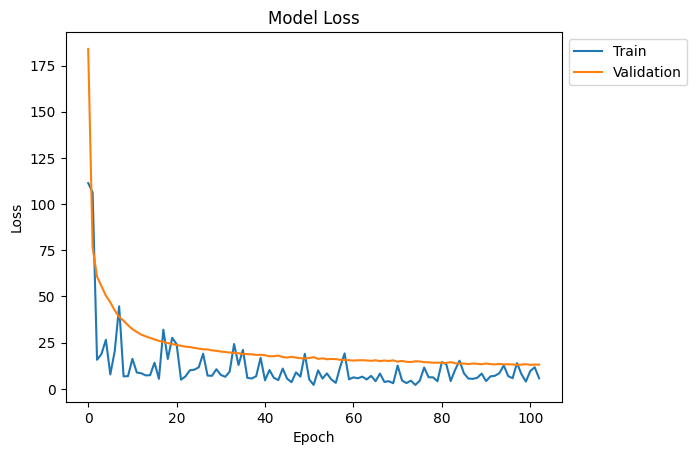

In [ ]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

In [ ]:
l_map

{'I-ORG': 0,
 'I-LOC': 1,
 'B-LOC': 2,
 'O': 3,
 'B-ORG': 4,
 'B-PER': 5,
 'I-MISC': 6,
 'B-MISC': 7,
 'I-PER': 8,
 '<start>': 9,
 '<pad>': 10}

In [ ]:
from sklearn.metrics import f1_score
import numpy as np

y_true = []
y_pred = []

for batch_x, batch_y in test_gen:
    predictions = model.predict(batch_x)
    y_true.extend(batch_y.argmax(axis=-1).flatten())
    y_pred.extend(predictions.argmax(axis=-1).flatten())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
f1 = f1_score(y_true, y_pred, average='macro')
print(f'F1 Score on the test data: {f1:.4f}')

1/1 [==============================] - 0s 104ms/step
F1 Score on the test data: 1.0000


In [ ]:
from underthesea import pos_tag

sentence = ["ông", "Khoa", "dân", "tỉnh", "Kiên_Giang", "tại", "trường_đại_học", "Quốc_Tế",
            "có", "tài_khoản", "Facebook", "và", "tài_khoản", "Youtube", "là", "Huy_Châu"]

pos_tags = [t[1] for t in pos_tag(' '.join(sentence))]
caps = [True if word[0].isupper() else False for word in sentence]
sentence_tuples = list(zip(sentence, pos_tags, caps))

encoded_sentence = encode_safe([sentence_tuples], f_map_emb, f_map_emb[('<unk>', '<unk>', False)])[0]
encoded_sentence

[1817, 1402, 1730, 2080, 914, 105, 0, 0, 423, 6048, 384, 0, 6048, 0, 1030, 0]

In [ ]:
def single_sentence_threshold(encoded_sentence):
    return [len(encoded_sentence) + 1]
def construct_bucket_vb_for_inference(input_features, thresholds, pad_feature, pad_label, label_size):

    buckets = [[[], [], []] for _ in range(len(thresholds))]
    for feature in input_features:

        cur_len = len(feature)
        idx = 0
        cur_len_1 = cur_len + 1
        while thresholds[idx] < cur_len_1:
            idx += 1
        buckets[idx][0].append(feature + [pad_feature] * (thresholds[idx] - cur_len))

        dummy_labels = [0] * (cur_len_1)
        buckets[idx][1].append([dummy_labels[ind] * label_size + dummy_labels[ind + 1] for ind in range(0, cur_len_1 - 1)] + [0])

        buckets[idx][2].append([1] * cur_len_1 + [0] * (thresholds[idx] - cur_len_1))

    bucket_dataset = [(np.array(bucket[0]), np.array(bucket[1]), np.array(bucket[2])) for bucket in buckets]
    return bucket_dataset

thresholds = single_sentence_threshold(encoded_sentence)
bucketed_data = construct_bucket_vb_for_inference([encoded_sentence], thresholds,
                                                  f_map_emb[('<eof>', '<eof>', False)], l_map['<pad>'], len(l_map))

In [ ]:
def decode_predictions(preds, label_map):
    decoded = []
    for pred in preds:
        prev_label = pred // len(label_map)
        curr_label = pred % len(label_map)
        decoded.append((prev_label, curr_label))

    label_map_inv = {v: k for k, v in label_map.items()}
    decoded_labels = [label_map_inv[curr_label] for _, curr_label in decoded]

    return decoded_labels

In [ ]:
bucketed_input, _, _ = bucketed_data[0]
predictions = model.predict(bucketed_input)

decoded_labels = decode_predictions(predictions[0], l_map)
print(decoded_labels)

1/1 [==============================] - 1s 1s/step
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', '<pad>']


##LM-LSTM-CRF

In [ ]:
!python /content/LM-LSTM-CRF/train_wc.py --emb_file /content/glove.6B.100d.txt --train_file /content/vtner/data/train.conll --dev_file /content/vtner/data/dev.conll --test_file /content/vtner/data/test.conll --gpu 0 --batch_size 64 --drop_out 0.5 --epoch 1000 --lr 0.01 --lr_decay 0 --update sgd --clip_grad 5.0  --checkpoint /content/drive/MyDrive/NERmodel/ --caseless --fine_tune --eva_matrix fa --patience 10

setting:
Namespace(rand_embedding=False, emb_file='/content/glove.6B.100d.txt', train_file='/content/vtner/data/train.conll', dev_file='/content/vtner/data/dev.conll', test_file='/content/vtner/data/test.conll', gpu=0, batch_size=64, unk='unk', char_hidden=300, word_hidden=300, drop_out=0.5, epoch=1000, start_epoch=0, checkpoint='/content/drive/MyDrive/NERmodel/', caseless=True, char_dim=30, word_dim=100, char_layers=1, word_layers=1, lr=0.01, lr_decay=0.0, fine_tune=False, load_check_point='', load_opt=False, update='sgd', momentum=0.9, clip_grad=5.0, small_crf=True, mini_count=5, lambda0=1, co_train=False, patience=10, high_way=False, highway_layers=1, eva_matrix='fa', least_iters=50, shrink_embedding=False)
loading corpus
constructing coding table
feature size: '2004'
loading embedding
embedding size: '401500'
constructing dataset
building model
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent l

In [ ]:
!python /content/LM-LSTM-CRF/seq_wc.py --load_arg /content/drive/MyDrive/NERmodel/cwlm_lstm_crf.json --load_check_point /content/drive/MyDrive/NERmodel/cwlm_lstm_crf.model --gpu 0 --input_file /content/inference.txt --output_file lm_lstm_crf.txt

loading dictionary
loading corpus
loading model
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
annotating
 - Process:   0% 0/1 [00:00<?, ?it/s]/content/LM-LSTM-CRF/model/crf.py:372: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/cuda/Indexing.cu:1440.)
  cur_bp.masked_fill_(mask[idx].view(bat_size, 1).expand(bat_size, self.tagset_size), self.end_tag)


In [ ]:
with open('/content/lm_lstm_crf.txt', 'r') as file:
    for line in file:
        print(line, end='')

-DOCSTART- -DOCSTART- -DOCSTART-

ông <PER> Huy </PER> dân <LOC> tỉnh Đồng_Nai </LOC> tại trường_đại_học <LOC> Quốc_Tế </LOC> có tài_khoản <MISC> Facebook </MISC> và tài_khoản <ORG> Youtube </ORG> là <PER> Huy_Châu </PER> 



##LSTM-CRF-highway-cotrain

In [ ]:
!python /content/LM-LSTM-CRF/train_wc.py --emb_file /content/glove.6B.100d.txt --train_file /content/vtner/data/train.conll --dev_file /content/vtner/data/dev.conll --test_file /content/vtner/data/test.conll --gpu 0 --batch_size 64 --drop_out 0.5 --epoch 1000 --lr 0.01 --lr_decay 0 --update sgd --clip_grad 5.0  --checkpoint /content/drive/MyDrive/LM-LSTM-CRF-highway/ --caseless --fine_tune --high_way --co_train --eva_matrix fa --patience 10

setting:
Namespace(rand_embedding=False, emb_file='/content/glove.6B.100d.txt', train_file='/content/vtner/data/train.conll', dev_file='/content/vtner/data/dev.conll', test_file='/content/vtner/data/test.conll', gpu=0, batch_size=64, unk='unk', char_hidden=300, word_hidden=300, drop_out=0.5, epoch=1000, start_epoch=0, checkpoint='/content/drive/MyDrive/LM-LSTM-CRF-highway/', caseless=True, char_dim=30, word_dim=100, char_layers=1, word_layers=1, lr=0.01, lr_decay=0.0, fine_tune=False, load_check_point='', load_opt=False, update='sgd', momentum=0.9, clip_grad=5.0, small_crf=True, mini_count=5, lambda0=1, co_train=True, patience=10, high_way=True, highway_layers=1, eva_matrix='fa', least_iters=50, shrink_embedding=False)
loading corpus
constructing coding table
feature size: '2004'
loading embedding
embedding size: '401500'
constructing dataset
building model
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last re

In [ ]:
!python /content/LM-LSTM-CRF/seq_wc.py --load_arg /content/drive/MyDrive/LM-LSTM-CRF-highway/cwlm_lstm_crf.json --load_check_point /content/drive/MyDrive/LM-LSTM-CRF-highway/cwlm_lstm_crf.model --gpu 0 --input_file /content/inference.txt --output_file lm_lstm_crf_highway.txt

loading dictionary
loading corpus
loading model
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
annotating
 - Process:   0% 0/1 [00:00<?, ?it/s]/content/LM-LSTM-CRF/model/crf.py:372: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/cuda/Indexing.cu:1440.)
  cur_bp.masked_fill_(mask[idx].view(bat_size, 1).expand(bat_size, self.tagset_size), self.end_tag)


In [ ]:
with open('/content/lm_lstm_crf_highway.txt', 'r') as file:
    for line in file:
        print(line, end='')

-DOCSTART- -DOCSTART- -DOCSTART-

ông <PER> Huy </PER> dân <LOC> tỉnh Đồng_Nai </LOC> tại trường_đại_học <LOC> Quốc_Tế </LOC> có tài_khoản <MISC> Facebook </MISC> và tài_khoản <ORG> Youtube </ORG> là <PER> Huy_Châu </PER> 

